This notebook shows that RNN does not reuse knowledge about the previously learned words to compose

Artificially induce hidden layer activation helps RNN to behave like a compositional learner 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
sys.path.append(os.getcwd())
from RNN_util import *
from sklearn.cluster import KMeans
import copy

In [2]:
class LookupTable:
    """A lookup table to store the input unit correspond to RNN's internal hidden state"""
    def __init__(self):
        self.mapping = {}

    def train(self, input_symbols, output_symbols):
        self.mapping[input_symbols] = output_symbols

    def predict(self, input_symbol):
        return self.mapping.get(input_symbol, None)

In [3]:
# more complex vocabulary
vocab = ['ABCD', 'GHI', 'JKLMN','E']
sequence = 'E'
for _ in range(0,1000):
    sequence = sequence + np.random.choice(vocab) + 'E'*np.random.randint(0,10)
    
# Create a dictionary to convert characters to integers
char_to_int = {char: i for i, char in enumerate(''.join(vocab))}
# Create a dictionary to convert integers to characters
int_to_char = {i: char for i, char in enumerate(''.join(vocab))}


# RNN Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [4]:
# Model parameters
hidden_size = 12
input_size = len(char_to_int)
output_size = len(char_to_int)
rnn = RNN(input_size, hidden_size, output_size) # 1 is transfer
rnn, hidden_states, hidden_seq,_,_,_ = train_rnn(rnn, sequence, input_size, char_to_int, int_to_char,n_iters = 160,print_every = 100,chunk_len = 400)

Iteration 100 loss: 0.8113168334960937 acc: 0.7775


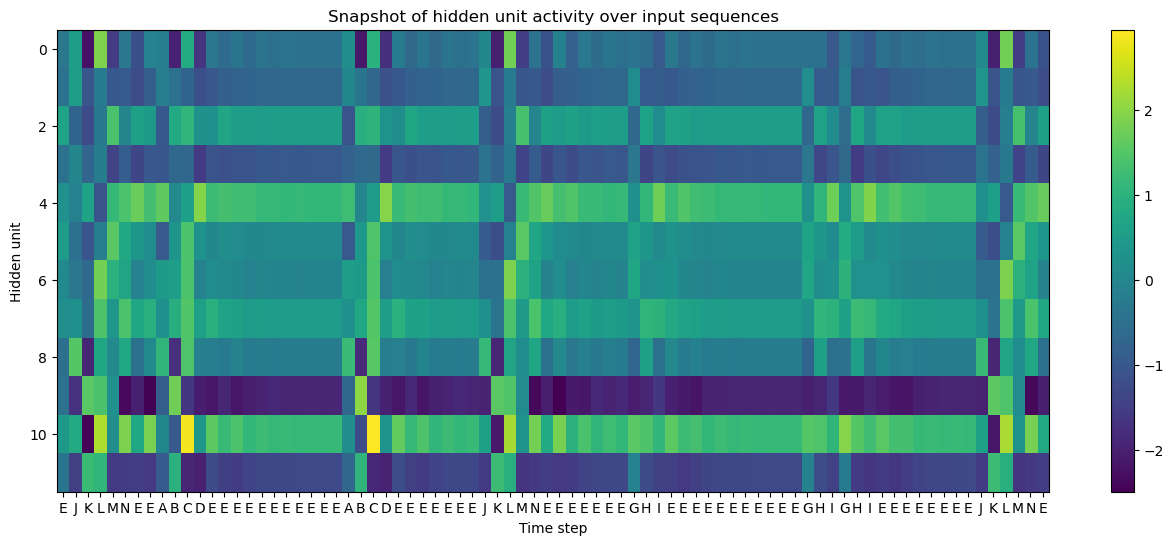

In [5]:
hidden_states = np.array(hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T
plt.figure(figsize=(16, 6))
plt.imshow(hidden_unit_activity[:,:80], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(hidden_seq[:80])),list(hidden_seq[:80]))
plt.title('Snapshot of hidden unit activity over input sequences')
plt.show()

## Then Learn Neural Clusters

In [6]:
# convert hidden unit activity on a continous time scale to symbolic 

def learn_neural_clusters(hidden_unit_activity):
    n_neurons = 12
    num_bins = 5 # 5 clusters for each hidden units for now
    cluster_center_record = np.zeros([n_neurons, num_bins]) # record the cluster center for each neuron
    symbolic_hidden_activity = []
    for i in range(0, hidden_unit_activity.shape[0]):
        data = hidden_unit_activity[i,:].reshape([-1,1])  # 1000 data points
        kmeans = KMeans(n_clusters=num_bins, random_state=0, n_init = 10).fit(data)# Apply K-means clustering
        binned_data = kmeans.predict(data) # Assign each data point to the nearest cluster center (bin)
        symbolic_hidden_activity.append(binned_data)
        cluster_center_record[i,:] = kmeans.cluster_centers_[:,0]   
    return cluster_center_record, symbolic_hidden_activity


# Assuming hidden_states is a list of numpy arrays
hidden_states = np.array(hidden_states)
hidden_unit_activity = hidden_states[:, 0, :].T
cluster_center_record, symbolic_hidden_activity = learn_neural_clusters(hidden_unit_activity)
symbolic_hidden_activity = np.array(symbolic_hidden_activity) # each label in each neuron is independent

state_trajectory = []
for i in range(0,symbolic_hidden_activity.shape[1]):
    state = ''.join(str(num) for num in symbolic_hidden_activity[:,i])
    state_trajectory.append(state)

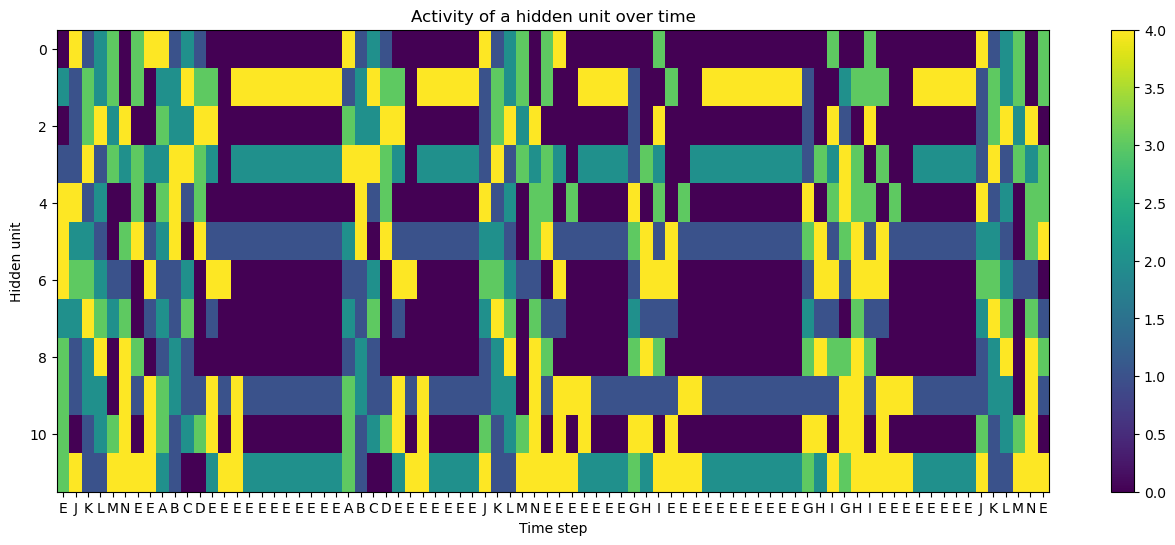

In [7]:
plt.figure(figsize=(16, 6))
plt.imshow(symbolic_hidden_activity[:,:80], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(hidden_seq[:80])),list(hidden_seq[:80]))
plt.title('Activity of a hidden unit over time')
plt.show()

In [8]:
predictor = LookupTable()
# train the predictor on a subset of the hidden data
train_l = 300
# Train
for state_symbol, input_symbol in zip(state_trajectory[:train_l],hidden_seq[:train_l]):
    predictor.train(state_symbol, input_symbol)

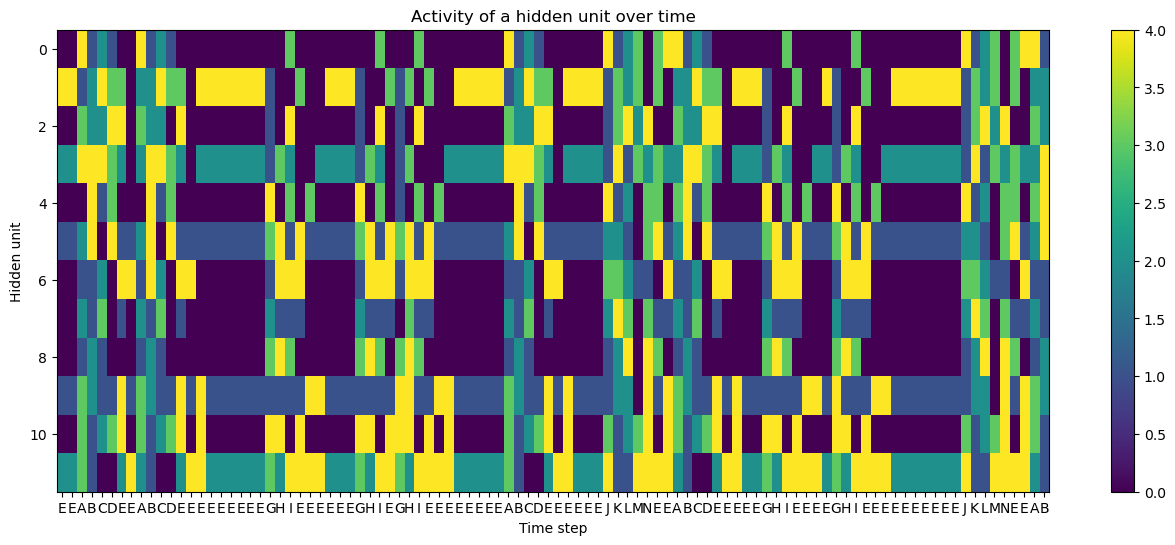

In [9]:
symbolic_hidden_activity = np.array(symbolic_hidden_activity) # each label in each neuron is independent
plt.figure(figsize=(16, 6))
plt.imshow(symbolic_hidden_activity[:,train_l:], aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('Time step')
plt.ylabel('Hidden unit')
plt.xticks(range(0, len(hidden_seq[train_l:])),list(hidden_seq[train_l:]))
plt.title('Activity of a hidden unit over time')
plt.show()

In [10]:

# test the predictor on another subset of the hidden neural activity 
# Predict
acc = 0
prediction_record = {}

for key in list(char_to_int.keys()):
    prediction_record[key] = np.zeros([len(hidden_seq[train_l:])])

i=0
for state_symbol, input_symbol in zip(state_trajectory[train_l:],hidden_seq[train_l:]):
    predicted_output = predictor.predict(state_symbol)
    acc = acc + int(predicted_output == input_symbol) 
    if predicted_output!=None:
        prediction_record[predicted_output][i] = 1
    i = i + 1
    
acc = acc/len(hidden_seq[train_l:])
print('prediction accuracy is {}: '.format(acc))
# sometimes A is not predicted, this is because look up table has not seen the state before 

prediction accuracy is 0.97: 


In [11]:
print(predictor.mapping)

{'020144423333': 'E', '411142321104': 'J', '133412342211': 'K', '224121234221': 'L', '332300120034': 'M', '004203134444': 'N', '330334003104': 'E', '400201410444': 'E', '423232121332': 'A', '122444112211': 'B', '242410231120': 'C', '134334000130': 'D', '034201410442': 'E', '000001400104': 'E', '040201000444': 'E', '040201000102': 'E', '413402121333': 'A', '411142321134': 'J', '332300100034': 'M', '004233134444': 'N', '330334013104': 'E', '000031000404': 'E', '040201000442': 'E', '011143123143': 'G', '000304414142': 'H', '304231413104': 'I', '030004410144': 'E', '000201000404': 'E', '021443103443': 'G', '030334434444': 'H', '334031413104': 'I', '030304410444': 'E', '000001000404': 'E', '413202121333': 'A', '411412321134': 'J', '133212342211': 'K', '034233134444': 'N', '011412321430': 'J', '011113103443': 'G', '030304434442': 'H', '304031413104': 'I', '030304414142': 'H', '421232121332': 'A', '134334000430': 'D', '011143123443': 'G', '411112301400': 'J', '133202342211': 'K', '13230010003

# then transfer on test sequences

In [12]:
# more complex vocabulary
vocab = ['ABCDLMN', 'E'] # 'JKLMN',
sequence = 'E'
for _ in range(0,1000):
    sequence = sequence + np.random.choice(vocab) + 'E'*np.random.randint(0,10)
    
transfer_sequence = sequence

In [13]:
def train_new_sequence(rnn, sequence, predictor,perturb = False):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)

    # Training
    n_iters = 100
    print_every = 100
    chunk_len = 100  # Length of a chunk of the sequence used for one training batch
    hidden_states = []
    hidden_seq = []
    acc_record = []

    for iter in range(1, n_iters + 1):
        rnn.zero_grad()
        loss = 0
        hidden = rnn.initHidden()

        # Random start index to slice the sequence
        start_index = torch.randint(len(sequence) - chunk_len, (1,)).item()
        end_index = start_index + chunk_len + 1
        chunk = sequence[start_index:end_index]

        # Prepare input and target sequences
        acc = 0
        for i in range(chunk_len):
            input_char = chunk[i] # 'D'
            target_char = chunk[i + 1] # 'L'
            input_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
            target_tensor = torch.tensor([char_to_int[target_char]], dtype=torch.long)
            
            # ABCDLMN
            if perturb and input_char == 'D':
                    perturb_char = 'J'# change history 
                    perturbed_hidden_state = state_transport(cluster_center_record,state_string = generate_state_from_predictor(predictor, perturb_char))
                    input_char == 'K'
                    perturb_tensor = torch.nn.functional.one_hot(torch.tensor([char_to_int[input_char]], dtype=torch.long), num_classes=input_size).type(torch.float)
                    # input tensor is 'K' 
                    output,hidden = rnn(perturb_tensor, perturbed_hidden_state)
#                     output,hidden = rnn(input_tensor, perturbed_hidden_state)
                    predict_char = int_to_char[output.argmax(1).item()]
                    #print('input character ', input_char, 'predicted character after perturbation ', predict_char)
            
            else:
                output, hidden = rnn(input_tensor, hidden)
                predict_char = int_to_char[output.argmax(1).item()]
                #print('input character ', input_char,'predicted character ', predict_char)
            if predict_char == target_char: acc = acc + 1

            loss += criterion(output, target_tensor)
            if iter == 160:
                hidden_states.append(hidden.detach().numpy())  # detach from the graph and convert to numpy
                hidden_seq.append(input_char)
        acc = acc/chunk_len

        acc_record.append(acc)
        loss.backward()
        optimizer.step()

        if iter % print_every == 0:
            print(f'Iteration {iter} loss: {loss.item() / chunk_len} acc: {acc}')
    return rnn, acc_record


In [14]:

controlrnn = copy.deepcopy(rnn)
perturbrnn = copy.deepcopy(rnn)
controlrnn, acc_record_control = train_new_sequence(controlrnn, transfer_sequence,predictor, perturb = False)
perturbrnn, acc_record_perturb = train_new_sequence(perturbrnn, transfer_sequence,predictor, perturb = True)

Iteration 100 loss: 0.23622093200683594 acc: 0.95
Iteration 100 loss: 0.29723655700683593 acc: 0.93


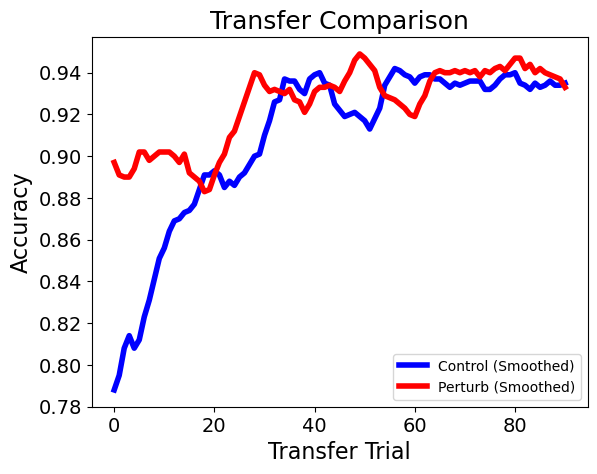

In [15]:
L = 200
np.random.seed(0)  # For reproducibility

# Moving average function
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing
window_size = 10  # Adjust the window size for more or less smoothing
smoothed_control = moving_average(acc_record_control, window_size)
smoothed_perturb = moving_average(acc_record_perturb, window_size)

# Adjust the x-axis to match the reduced length after smoothing
x_control = np.arange(len(smoothed_control))
x_perturb = np.arange(len(smoothed_perturb))

# Plot the smoothed lines
# plt.figure(figsize=(8, 6))  # Adjust figure size
plt.plot(x_control, smoothed_control, label='Control (Smoothed)', color='blue', linewidth=4)  # Smoothed Line 1
plt.plot(x_perturb, smoothed_perturb, label='Perturb (Smoothed)', color='red', linewidth=4)  # Smoothed Line 2


# Adjust text size
plt.xlabel('Transfer Trial', fontsize=16)  # Increase font size for x-axis label
plt.ylabel('Accuracy', fontsize=16)       # Increase font size for y-axis label
plt.title('Transfer Comparison', fontsize=18)  # Increase font size for title
plt.xticks(fontsize=14)  # Increase font size for x-axis ticks
plt.yticks(fontsize=14)  # Increase font size for y-axis ticks
plt.legend(fontsize=14)  # Increase font size for legend

# Add legend
plt.legend()

# Show plot
plt.show()


# do more experiments

In [ ]:
n_experiment = 30
acc_control = []
acc_perturb = []

for _ in range(0, n_experiment):
    vocab = ['ABCD', 'GHI', 'JKLMN','E']
    sequence = 'E'
    for _ in range(0,1000):
        sequence = sequence + np.random.choice(vocab) + 'E'*np.random.randint(0,10)

    # Create a dictionary to convert characters to integers
    char_to_int = {char: i for i, char in enumerate(''.join(vocab))}
    # Create a dictionary to convert integers to characters
    int_to_char = {i: char for i, char in enumerate(''.join(vocab))}

    # Model parameters
    hidden_size = 12
    input_size = len(char_to_int)
    output_size = len(char_to_int)

    rnn = RNN(input_size, hidden_size, output_size) # 1 is transfer
    rnn, hidden_states, hidden_seq,_,_,_ = train_rnn(rnn, sequence, input_size, char_to_int, int_to_char,n_iters = 160,print_every = 100,chunk_len = 400)
    
    # Assuming hidden_states is a list of numpy arrays
    hidden_states = np.array(hidden_states)
    hidden_unit_activity = hidden_states[:, 0, :].T
    cluster_center_record, symbolic_hidden_activity = learn_neural_clusters(hidden_unit_activity)
    symbolic_hidden_activity = np.array(symbolic_hidden_activity) # each label in each neuron is independent

    state_trajectory = []
    for i in range(0,symbolic_hidden_activity.shape[1]):
        state = ''.join(str(num) for num in symbolic_hidden_activity[:,i])
        state_trajectory.append(state)
    predictor = LookupTable()
    # train the predictor on a subset of the hidden data
    train_l = 300
    # Train
    for state_symbol, input_symbol in zip(state_trajectory[:train_l],hidden_seq[:train_l]):
        predictor.train(state_symbol, input_symbol)

    # test the predictor on another subset of the hidden neural activity 
    # Predict
    acc = 0
    prediction_record = {}

    for key in list(char_to_int.keys()):
        prediction_record[key] = np.zeros([len(hidden_seq[train_l:])])

    i=0
    for state_symbol, input_symbol in zip(state_trajectory[train_l:],hidden_seq[train_l:]):
        predicted_output = predictor.predict(state_symbol)
        acc = acc + int(predicted_output == input_symbol) 
        if predicted_output!=None:
            prediction_record[predicted_output][i] = 1
        i = i + 1

    acc = acc/len(hidden_seq[train_l:])
    print('prediction accuracy is {}: '.format(acc))

    # more complex vocabulary
    vocab = ['ABCDLMN', 'E'] # 'JKLMN',
    sequence = 'E'
    for _ in range(0,1000):
        sequence = sequence + np.random.choice(vocab) + 'E'*np.random.randint(0,10)

    transfer_sequence = sequence
    controlrnn = copy.deepcopy(rnn)
    perturbrnn = copy.deepcopy(rnn)
    controlrnn, acc_record_control = train_new_sequence(controlrnn, transfer_sequence,predictor,perturb = False)
    perturbrnn, acc_record_perturb = train_new_sequence(perturbrnn, transfer_sequence,predictor,perturb = True)
    acc_control.append(acc_record_control)
    acc_perturb.append(acc_record_perturb)
    # sometimes A is not predicted, this is because look up table has not seen the state before 

Iteration 100 loss: 0.8879454040527344 acc: 0.7875
prediction accuracy is 0.95: 
Iteration 100 loss: 0.2402414321899414 acc: 0.95
Iteration 100 loss: 0.2863241958618164 acc: 0.93
Iteration 100 loss: 0.6796659088134765 acc: 0.835
prediction accuracy is 0.96: 
Iteration 100 loss: 0.25059101104736325 acc: 0.95
Iteration 100 loss: 0.2614803695678711 acc: 0.93
Iteration 100 loss: 0.871834716796875 acc: 0.8175
prediction accuracy is 1.0: 
Iteration 100 loss: 0.25030471801757814 acc: 0.95
Iteration 100 loss: 0.2653851318359375 acc: 0.93
Iteration 100 loss: 0.8326091003417969 acc: 0.8025
prediction accuracy is 0.91: 
Iteration 100 loss: 0.314502010345459 acc: 0.92
Iteration 100 loss: 0.2633708190917969 acc: 0.94
Iteration 100 loss: 0.7137104797363282 acc: 0.815
prediction accuracy is 0.98: 
Iteration 100 loss: 0.2610512924194336 acc: 0.94
Iteration 100 loss: 0.22878292083740234 acc: 0.94
Iteration 100 loss: 0.9706870269775391 acc: 0.7475
prediction accuracy is 0.95: 
Iteration 100 loss: 0.2840

In [ ]:
L = 100

# Convert lists of lists to numpy arrays for easier computation
acc_record_control = np.array(acc_control)  # Shape: (num_runs, L)
acc_record_perturb = np.array(acc_perturb)  # Shape: (num_runs, L)

# Calculate mean and confidence intervals
mean_control = acc_record_control.mean(axis=0)
mean_perturb = acc_record_perturb.mean(axis=0)

# Confidence interval: standard error of the mean (SEM)
sem_control = acc_record_control.std(axis=0) / np.sqrt(acc_record_control.shape[0])
sem_perturb = acc_record_perturb.std(axis=0) / np.sqrt(acc_record_perturb.shape[0])

# 95% Confidence Interval (using Z = 1.96 for large samples)
z = 1.96
ci_control_upper = mean_control + z * sem_control
ci_control_lower = mean_control - z * sem_control
ci_perturb_upper = mean_perturb + z * sem_perturb
ci_perturb_lower = mean_perturb - z * sem_perturb

# Plot control with confidence intervals
plt.plot(mean_control, label='Control', color='blue', linewidth=4)
plt.fill_between(np.arange(L), ci_control_lower, ci_control_upper, 
                 color='blue', alpha=0.2, label='Control 95% CI')

# Plot perturb with confidence intervals
plt.plot(mean_perturb, label='Perturb', color='red', linewidth=4)
plt.fill_between(np.arange(L), ci_perturb_lower, ci_perturb_upper, 
                 color='red', alpha=0.2, label='Perturb 95% CI')


# Add labels and title
plt.xlabel('Transfer Trial', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Transfer Comparison', fontsize=18)
plt.legend(fontsize=14)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show plot
plt.show()


In [ ]:
L = 100

# Convert lists of lists to numpy arrays for easier computation
acc_record_control = np.array(acc_control)  # Shape: (num_runs, L)
acc_record_perturb = np.array(acc_perturb)  # Shape: (num_runs, L)

# Calculate mean and confidence intervals
mean_control = acc_record_control.mean(axis=0)
mean_perturb = acc_record_perturb.mean(axis=0)

# Confidence interval: standard error of the mean (SEM)
sem_control = acc_record_control.std(axis=0) / np.sqrt(acc_record_control.shape[0])
sem_perturb = acc_record_perturb.std(axis=0) / np.sqrt(acc_record_perturb.shape[0])

# 95% Confidence Interval (using Z = 1.96 for large samples)
z = 1.96
ci_control_upper = mean_control + z * sem_control
ci_control_lower = mean_control - z * sem_control
ci_perturb_upper = mean_perturb + z * sem_perturb
ci_perturb_lower = mean_perturb - z * sem_perturb

# Plot control with confidence intervals
plt.plot(mean_control, label='Control', color='blue', linewidth=4)
plt.fill_between(np.arange(L), ci_control_lower, ci_control_upper, 
                 color='blue', alpha=0.2, label='Control 95% CI')

# Plot perturb with confidence intervals
plt.plot(mean_perturb, label='Perturb', color='red', linewidth=4)
plt.fill_between(np.arange(L), ci_perturb_lower, ci_perturb_upper, 
                 color='red', alpha=0.2, label='Perturb 95% CI')


# Add labels and title
plt.xlabel('Transfer Trial', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Transfer Comparison', fontsize=18)
plt.legend(fontsize=14)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show plot
plt.show()
